In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings("ignore")

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 10000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)  # (L, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, L, d_model)

    def forward(self, x):
        # x: (B, L, d_model)
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


def causal_mask(L: int, device=None):
    # shape: (L, L), True where masked
    mask = torch.triu(torch.ones(L, L, device=device, dtype=torch.bool), diagonal=1)
    return mask


class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        n_features: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        out_dim: int = 1,  # = num_classes для классификации
        problem_type: str = "regression",  # or "classification"
    ):
        super().__init__()
        self.problem_type = problem_type
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, out_dim),
        )

    def forward(self, x, src_key_padding_mask=None):
        # x: (B, L, n_features)
        B, L, _ = x.size()
        h = self.input_proj(x)
        h = self.pos_enc(h)
        mask = causal_mask(L, device=x.device)  # (L, L) True=masked
        h = self.encoder(h, mask=mask, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(h)  # (B, L, out_dim)
        return logits

In [3]:
df = pd.read_csv("../../data/frames_errors.csv", header=None)
df.columns = [
    "block_id",
    "frame_idx",
    "E_mu_Z",
    "E_mu_phys_est",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
    "nTot",
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
    "synErr",
    "N_EC_rounds",
    "maintenance_flag",
    "estimator_name",
    "f_EC",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

In [4]:
id_features = [
    "block_id",
    "frame_idx",
]

phys_gt_features = [
    "E_mu_Z",
    "E_mu_X",
    "E_nu1_X",
    "E_nu2_X",
    "E_nu1_Z",
    "E_nu2_Z",
    "N_mu_X",
    "M_mu_XX",
    "M_mu_XZ",
    "M_mu_X",
    "N_mu_Z",
    "M_mu_ZZ",
    "M_mu_Z",
    "N_nu1_X",
    "M_nu1_XX",
    "M_nu1_XZ",
    "M_nu1_X",
    "N_nu1_Z",
    "M_nu1_ZZ",
    "M_nu1_Z",
    "N_nu2_X",
    "M_nu2_XX",
    "M_nu2_XZ",
    "M_nu2_X",
    "N_nu2_Z",
    "M_nu2_ZZ",
    "M_nu2_Z",
]

phys_features = [
    "bayesImVoltage",
    "opticalPower",
    "polarizerVoltages[0]",
    "polarizerVoltages[1]",
    "polarizerVoltages[2]",
    "polarizerVoltages[3]",
    "temp_1",
    "biasVoltage_1",
    "temp_2",
    "biasVoltage_2",
]

est_features = [
    # "E_mu_phys_est",
    "E_mu_Z_est",
    "R",
    "s",
    "p",
]

proxy_features = [
    "N_EC_rounds",
    # "f_EC",
]

df = df[id_features + phys_gt_features + phys_features + est_features + proxy_features]

In [5]:
def lag_features(df, features, lag):
    df = df.copy()
    lagged_features = []

    for feature in features:
        for l in lag:
            df[f"{feature}_lag_{l}"] = df.groupby("block_id")[feature].shift(l)
            lagged_features.append(f"{feature}_lag_{l}")

    df = df.bfill().ffill()
    return df, lagged_features

In [6]:
features_to_create = phys_features + phys_gt_features + est_features
df, lagged_features = lag_features(df, features_to_create, lag=[2, 5, 10])

<Axes: >

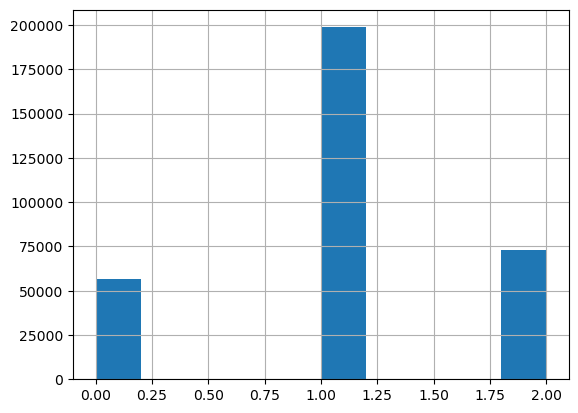

In [7]:
def categorize_n_ec_rounds(n):
    if n == 1 or n == 2 or n == 3:
        return 1
    elif 4 <= n <= 10:
        return 2
    return 0


df["N_EC_rounds_cat"] = df["N_EC_rounds"].apply(categorize_n_ec_rounds)
df["N_EC_rounds_cat"].hist()

In [8]:
# Test (Val)
start_idx = df[(df["block_id"] == 1489460492) & (df["frame_idx"] == 99)].index[0]
end_idx = df[(df["block_id"] == 1840064900) & (df["frame_idx"] == 101)].index[0]

test_df = df.loc[start_idx:end_idx].copy()
assert len(test_df) == 2000, "Test (Val) set size is not 2000 rows"

# Train
all_block_ids = df["block_id"].unique()
train_blocks = [bid for bid in all_block_ids if bid not in test_df["block_id"].values]

train_df = df[df["block_id"].isin(train_blocks)]

print(f"Train: {len(train_df['block_id'])}")

Train: 326221


In [9]:
feature_cols = phys_features + lagged_features + ["E_mu_Z_est", "R", "s", "p"]
target_col = "N_EC_rounds_cat"

In [10]:
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

train_df.loc[:, feature_cols] = scaler.transform(train_df[feature_cols])
test_df.loc[:, feature_cols] = scaler.transform(test_df[feature_cols])

train_df.loc[:, feature_cols] = train_df[feature_cols].astype(np.float32)
test_df.loc[:, feature_cols] = test_df[feature_cols].astype(np.float32)

In [11]:
def get_seqences(df, feature_cols, target_col):
    groups = df.groupby("block_id")
    sequences = []
    for block_id, g in groups:
        x = torch.tensor(g[feature_cols].values, dtype=torch.float32)  # (L_i, F)
        y = torch.tensor(g[target_col].values, dtype=torch.float32).unsqueeze(-1)  # (L_i, 1)
        sequences.append((x, y))
    return sequences

In [12]:
train_seqs = get_seqences(train_df, feature_cols, target_col)
val_seqs = get_seqences(test_df, feature_cols, target_col)

In [13]:
class SeqDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx]


def collate_pad(batch, pad_value: float = 0.0):
    # batch: list of (x_i: (L_i,F), y_i: (L_i,1))
    xs, ys = zip(*batch)
    lengths = torch.tensor([t.size(0) for t in xs], dtype=torch.long)  # (B,)
    X = torch.nn.utils.rnn.pad_sequence(
        xs, batch_first=True, padding_value=pad_value
    )  # (B, Lmax, F)
    Y = torch.nn.utils.rnn.pad_sequence(ys, batch_first=True, padding_value=0.0)  # (B, Lmax, 1)
    B, Lmax, _ = X.shape
    ar = torch.arange(Lmax).expand(B, Lmax)
    pad_mask = ar >= lengths.unsqueeze(1)  # True там, где паддинг: (B, Lmax), bool
    loss_mask = (~pad_mask).unsqueeze(-1)  # (B, Lmax, 1) для маскирования лосса
    return X, Y, pad_mask, loss_mask, lengths

In [14]:
train_dataset = SeqDataset(train_seqs)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_pad)

val_dataset = SeqDataset(val_seqs)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_pad)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = len(feature_cols)
num_classes = 3
model = TimeSeriesTransformer(
    n_features=n_features,
    out_dim=num_classes,
    d_model=128,
    dim_feedforward=256,
    problem_type="classification",
).to(device)
loss_fn = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
num_epochs = 500

In [16]:
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_sum, train_n = 0.0, 0.0
    train_correct, train_total = 0, 0

    for X, Y, pad_mask, loss_mask, lengths in train_loader:
        X, Y, pad_mask, loss_mask = (
            X.to(device),
            Y.to(device).long().squeeze(-1),  # (B, Lmax)
            pad_mask.to(device),
            loss_mask.to(device),
        )
        pred = model(X, src_key_padding_mask=pad_mask)  # (B, Lmax, num_classes)
        loss_map = loss_fn(pred.permute(0, 2, 1), Y)  # (B, Lmax)
        loss = (loss_map * loss_mask.squeeze(-1)).sum() / loss_mask.sum().clamp_min(1)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss_sum += (loss_map * loss_mask.squeeze(-1)).sum().item()
        train_n += loss_mask.sum().item()

        # Accuracy
        preds = pred.argmax(dim=-1)  # (B, Lmax)
        train_correct += ((preds == Y) * loss_mask.squeeze(-1)).sum().item()
        train_total += loss_mask.sum().item()

    train_loss = train_loss_sum / max(train_n, 1.0)
    train_acc = train_correct / max(train_total, 1.0)

    # Валидация
    model.eval()
    val_loss_sum, val_n = 0.0, 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for X, Y, pad_mask, loss_mask, lengths in val_loader:
            X, Y, pad_mask, loss_mask = (
                X.to(device),
                Y.to(device).long().squeeze(-1),
                pad_mask.to(device),
                loss_mask.to(device),
            )
            pred = model(X, src_key_padding_mask=pad_mask)
            loss_map = loss_fn(pred.permute(0, 2, 1), Y)
            val_loss_sum += (loss_map * loss_mask.squeeze(-1)).sum().item()
            val_n += loss_mask.sum().item()

            # Accuracy
            preds = pred.argmax(dim=-1)
            val_correct += ((preds == Y) * loss_mask.squeeze(-1)).sum().item()
            val_total += loss_mask.sum().item()

    val_loss = val_loss_sum / max(val_n, 1.0)
    val_acc = val_correct / max(val_total, 1.0)

    print(
        f"Epoch {epoch:02d} | train loss: {train_loss:.6f} | train acc: {train_acc:.4f} | val loss: {val_loss:.6f} | val acc: {val_acc:.4f}"
    )

Epoch 01 | train loss: 0.938366 | train acc: 0.5946 | val loss: 0.808101 | val acc: 0.6515
Epoch 02 | train loss: 0.871455 | train acc: 0.6110 | val loss: 0.781694 | val acc: 0.6625
Epoch 03 | train loss: 0.837176 | train acc: 0.6256 | val loss: 0.747830 | val acc: 0.6645
Epoch 04 | train loss: 0.807745 | train acc: 0.6390 | val loss: 0.728192 | val acc: 0.6660
Epoch 05 | train loss: 0.781234 | train acc: 0.6516 | val loss: 0.701952 | val acc: 0.6790
Epoch 06 | train loss: 0.749863 | train acc: 0.6664 | val loss: 0.704238 | val acc: 0.6800
Epoch 07 | train loss: 0.733924 | train acc: 0.6730 | val loss: 0.673086 | val acc: 0.6905
Epoch 08 | train loss: 0.712127 | train acc: 0.6819 | val loss: 0.659776 | val acc: 0.7025
Epoch 09 | train loss: 0.698786 | train acc: 0.6879 | val loss: 0.657309 | val acc: 0.7105
Epoch 10 | train loss: 0.689546 | train acc: 0.6908 | val loss: 0.638429 | val acc: 0.7185
Epoch 11 | train loss: 0.678593 | train acc: 0.6970 | val loss: 0.629715 | val acc: 0.7200

KeyboardInterrupt: 